In [ ]:
import os
import pandas as pd
import numpy as np

# Coordinate file (contain a column with station IDs)
COORD_FILE = "410_data/14_Station_Coordinates__Updated_.csv"
# Folder that contains all NCEI normals CSV files
DATA_DIR   = "410_data"
# Output file: stations × 365 matrix
OUT_FILE   = "410_data/matrix_14stations_365.csv"


coords = pd.read_csv(COORD_FILE)

# Here we assume the coordinate table has a column named "file"
# whose values look like USC00111577, USC00300183, ...
station_ids = coords["file"].astype(str).tolist()


def read_station_series(path):
    """
    From a single NCEI Daily Climate Normals file, extract a 365-length
    Tmean (DLY-TAVG-NORMAL) series indexed by day-of-year (1..365).

    The function:
      * finds a Tmean/TAVG normals column (case-insensitive),
      * builds a day-of-year index (1..366),
      * interpolates missing values,
      * removes DOY 366 (leap day) and returns only 1..365.
    """
    df = pd.read_csv(path, low_memory=False)

    #Find the Tmean column
    t_candidates = []
    for c in df.columns:
        cname = str(c).lower()
        if (
            "dly-tavg-normal" in cname
            or ("tavg" in cname and "normal" in cname)
            or ("tmean" in cname and "normal" in cname)
        ):
            t_candidates.append(c)

    if not t_candidates:
        raise ValueError(f"No Tmean-like column found in {os.path.basename(path)}")

    tcol = t_candidates[0]

    # Build day-of-year: 1 - 366
    cols_lower = {c: str(c).lower() for c in df.columns}
    doy_col = None

    #If the file already has a DOY/dayofyear/julian/yearday column, use it
    for c in df.columns:
        cl = cols_lower[c]
        if cl in ["doy", "dayofyear", "julian", "yearday"]:
            doy_col = c
            break

    if doy_col is not None:
        sub = df[[doy_col, tcol]].copy()
        sub[doy_col] = pd.to_numeric(sub[doy_col], errors="coerce")
        sub[tcol]    = pd.to_numeric(sub[tcol],    errors="coerce")
        sub = sub.dropna(subset=[doy_col, tcol])
        sub = sub[(sub[doy_col] >= 1) & (sub[doy_col] <= 366)]
        # If there are duplicate days, average them
        sub = sub.groupby(doy_col)[tcol].mean()
        series_full = pd.Series(index=range(1, 367), dtype=float)
        series_full.loc[sub.index.astype(int)] = sub.values

    # Otherwise, if there are month+day columns, compute DOY using year 2000
    elif {"month", "day"}.issubset(set(df.columns)):
        tmp = df[["month", "day", tcol]].copy()
        tmp["month"] = pd.to_numeric(tmp["month"], errors="coerce")
        tmp["day"]   = pd.to_numeric(tmp["day"],   errors="coerce")
        tmp[tcol]    = pd.to_numeric(tmp[tcol],    errors="coerce")
        tmp = tmp.dropna(subset=["month", "day", tcol])

        # Year 2000 is a leap year, so it can represent Feb 29 (DOY = 60)
        tmp["doy"] = pd.to_datetime(
            {
                "year": 2000,
                "month": tmp["month"].astype(int),
                "day":   tmp["day"].astype(int),
            },
            errors="coerce",
        ).dt.dayofyear

        tmp = tmp.dropna(subset=["doy"])
        tmp["doy"] = tmp["doy"].astype(int)
        tmp = tmp[(tmp["doy"] >= 1) & (tmp["doy"] <= 366)]

        sub = tmp.groupby("doy")[tcol].mean()
        series_full = pd.Series(index=range(1, 367), dtype=float)
        series_full.loc[sub.index] = sub.values

    #Fallback: assume the file is already one row per day in order
    else:
        s = pd.to_numeric(df[tcol], errors="coerce")
        series_full = pd.Series(index=range(1, 367), dtype=float)
        n = min(len(s), 366)
        series_full.iloc[:n] = s.iloc[:n].values

    #Interpolate and drop DOY 366 to get 365 days
    series_full = series_full.interpolate(limit_direction="both")

    # Keep only DOY 1..365
    series365 = series_full.iloc[:365]

    # Safety check: if there are still NaNs, interpolate again
    if series365.isna().any():
        series365 = series365.interpolate(limit_direction="both")

    return series365


# ==============================
# Main loop: build stations × 365 matrix
# ==============================

rows = []
good_ids = []

for sid in station_ids:
    f = os.path.join(DATA_DIR, f"{sid}.csv")
    if not os.path.exists(f):
        print("Missing file for station:", sid)
        continue

    try:
        series365 = read_station_series(f)
        if len(series365) != 365:
            raise ValueError(f"Got length {len(series365)} for {sid}")
        rows.append(series365.values)
        good_ids.append(sid)
    except Exception as e:
        print("Skip", sid, "->", e)

if rows:
    # Stack into a matrix: stations × 365
    X = np.vstack(rows)
    days = list(range(1, 366))

    matrix_df = pd.DataFrame(X, index=good_ids, columns=days)

    # Final QC: if any NaNs remain, interpolate along each row
    if matrix_df.isna().any().any():
        matrix_df = matrix_df.apply(
            lambda r: pd.Series(r).interpolate(limit_direction="both"), axis=1
        )
        matrix_df.index = good_ids
        matrix_df.columns = days

    matrix_df.to_csv(OUT_FILE)
    print("Saved:", OUT_FILE, "shape =", matrix_df.shape)
else:
    print("No station series were built; please check DATA_DIR and column names.")


FileNotFoundError: [Errno 2] No such file or directory: '410_data/14_Station_Coordinates__Updated_.csv'

# Fix the data

In [ ]:
df = pd.read_csv("/content/matrix.csv")

numeric_cols = []
for col in df.columns:
    try:
        float(df[col].iloc[0])
        numeric_cols.append(col)
    except:
        pass


df_clean = df[numeric_cols]

if "MEAN" in df_clean.columns or "mean" in df_clean.columns:
    df_clean = df_clean.drop(columns=["MEAN"], errors="ignore")

df_clean = df_clean.apply(pd.to_numeric, errors="coerce")

if "STATION" in df.columns:
    df_clean.index = df["STATION"]
elif "Unnamed: 0" in df.columns:
    df_clean.index = df["Unnamed: 0"]
else:
    print("⚠ No station ID found, using row numbers.")

print("Clean matrix shape:", df_clean.shape)

flow = df_clean.values
station_ids = df_clean.index.tolist()

Numeric columns found: 365
Clean matrix shape: (14, 365)


# Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
#!pip install minisom
from minisom import MiniSom


flow = df_clean.values
station_ids = df_clean.index.tolist()

print("Data ready:", flow.shape)


Data ready: (14, 365)


# SSA for first station

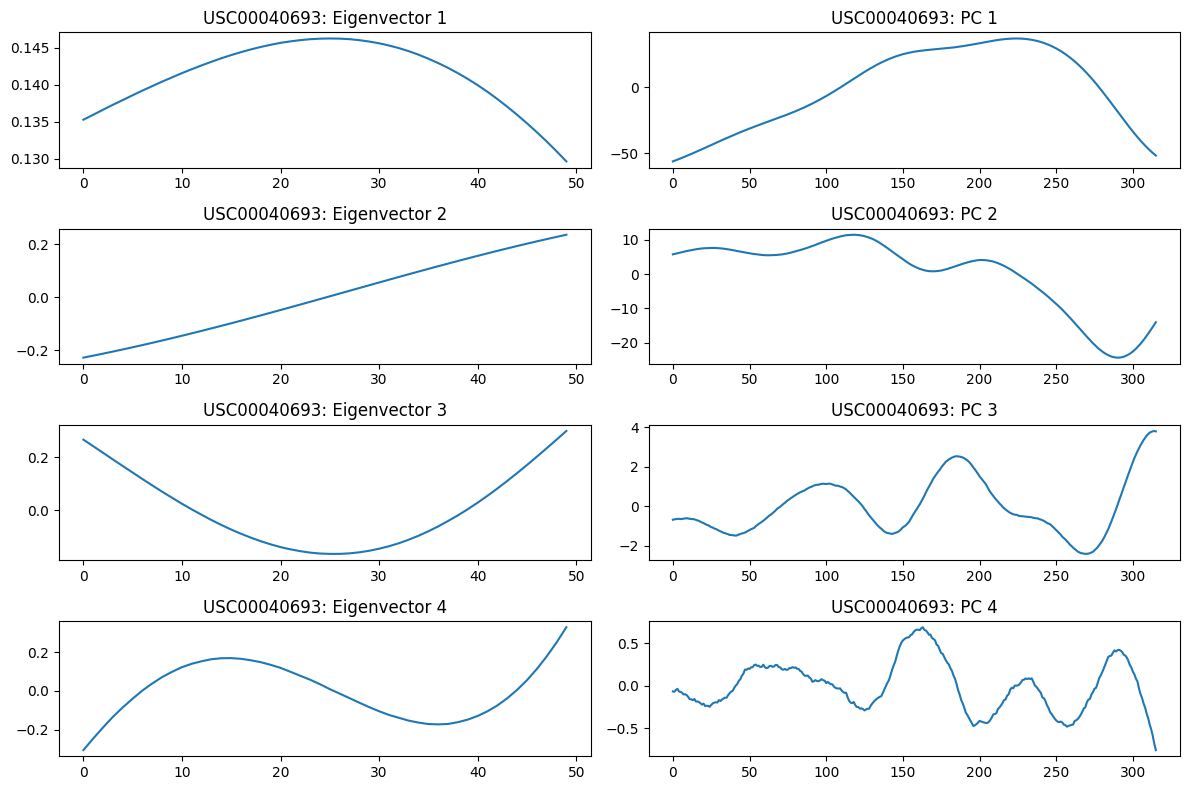

First 5 SSA mode variances: [8.88141946e-01 1.09732757e-01 1.99827238e-03 8.57495153e-05
 3.24610720e-06]


In [ ]:
def perform_ssa(series, L):
    N = len(series)
    K = N - L + 1
    X = np.column_stack([series[i:i+K] for i in range(L)])
    pca = PCA(n_components=L)
    PCs = pca.fit_transform(X)
    eigvecs = pca.components_
    fracVar = pca.explained_variance_ratio_
    return PCs, eigvecs, fracVar

# Use first station as example
sid0 = station_ids[0]
series0 = df_clean.loc[sid0].values
L = 50

PCs0, eig0, var0 = perform_ssa(series0, L)

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.plot(eig0[i])
    plt.title(f"{sid0}: Eigenvector {i+1}")

    plt.subplot(4,2,2*i+2)
    plt.plot(PCs0[:, i])
    plt.title(f"{sid0}: PC {i+1}")

plt.tight_layout()
plt.show()

print("First 5 SSA mode variances:", var0[:5])

Using **L = 50**, Singular Spectrum Analysis (SSA) decomposes the station’s annual
flow series into **50 orthogonal temporal patterns (eigenvectors)** and the
corresponding **principal components (PCs)** that describe how strongly each
pattern appears over time. Below is the interpretation of the first two SSA
modes, since they typically contain most of the variance.

---

## **Mode 1: Eigenvector 1**

### **Interpretation (trend–shape mode)**  
The first eigenvector is **smooth**, **unimodal**, and has a **broad seasonal-like curve**.  
This shape reflects the dominant low-frequency structure in the data, typically:

- an annual cycle  
- seasonal accumulation/melt  
- the main rising–falling pattern of the hydrograph  

### **Meaning**  
SSA Mode 1 represents the **overall yearly flow shape** or **dominant seasonal cycle**.

---

## **PC 1**

### **Interpretation (amplitude modulation)**  
PC1 shows how strongly Eigenvector 1 is expressed across the sliding windows.  
Smooth increases or decreases in PC1 indicate **seasonal shifts in the magnitude**  
of the main cycle.

### **Meaning**  
PC1 scales the seasonal pattern across the year, essentially a  
**seasonal intensity curve**.

---

## **Mode 2: Eigenvector 2**

### **Interpretation (trend / linear drift component)**  
This eigenvector is nearly **linear**, rising from negative to positive.  
This is characteristic of SSA capturing a **slow drift or long-term trend**,  
independent of the seasonal cycle.

### **Meaning**  
Mode 2 represents a **monotonic trend component**, such as:

- gradual wetting/drying  
- long-term shift in baseflow  
- upward/downward bias in part of the window  

---

## **PC 2**

### **Interpretation (trend modulation over the year)**  
PC2 oscillates with **lower amplitude** and **more mid-frequency structure**  
than PC1. It modifies the linear trend from Eigenvector 2 during different  
periods of the year.

### **Meaning**  
PC2 captures **changes in the rate of increase/decrease** of the underlying trend.

---


# Part 2) Ward hierarichcal clustering

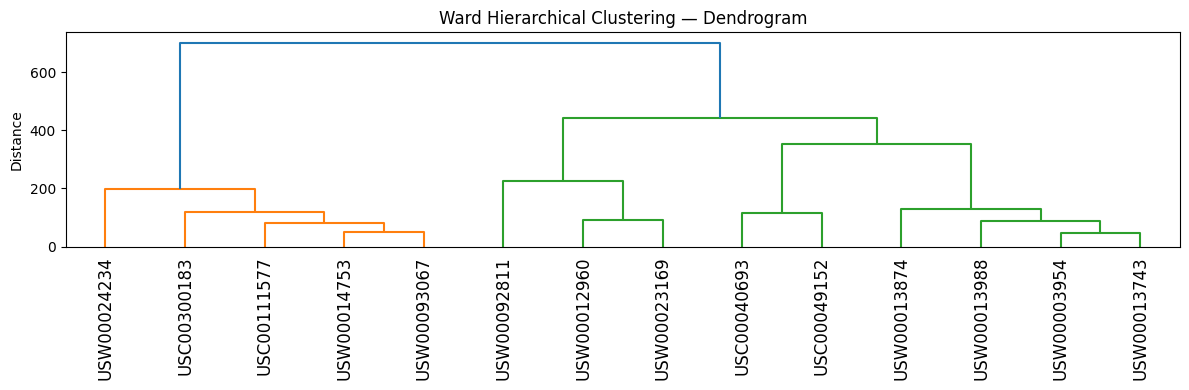

In [ ]:
Z = linkage(flow, method="ward")

plt.figure(figsize=(12,4))
dendrogram(Z, labels=station_ids, leaf_rotation=90)
plt.title("Ward Hierarchical Clustering — Dendrogram")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

## **Interpretation of the Ward Hierarchical Clustering Dendrogram**

The dendrogram groups the 14 stations based on the similarity of their annual
flow time series (each represented as a 365-dimensional vector). Ward’s method
merges stations or clusters that minimize the increase in within–cluster
variance.

---

## **1. Two Major Clusters**

A large split at a high linkage distance (approximately 650 ) indicates
two dominant hydrologic groups among the stations.

---

### **Cluster A (left side — orange group)**  
Stations:
- USW00024234  
- USC00300183  
- USC00111577  
- USW00014753  
- USW00093067  

**Characteristics:**  
- Merge at low distances (\(< 200\)), indicating *high similarity* in their flow regimes.  
- These stations likely share similar seasonal timing, magnitudes, or basin
hydroclimates.

---

### **Cluster B (right side — green group)**  
Stations:
- USW00092811  
- USW00012960  
- USW00023169  
- USC00040693  
- USC00049152  
- USW00013874  
- USW00013988  
- USW00013743  

**Characteristics:**  
- More spread out, merging at distances between \(150\) and \(350\).  
- Indicates greater internal variability, though still distinct from Cluster A.  
- May reflect differences in elevation, climate, or watershed properties.

---

## **2. Largest Jump Indicates Natural Grouping**

The tall vertical linkage separating the two main branches shows that merging
Clusters A and B greatly increases variance.  
This implies the presence of **two fundamentally different hydrologic regimes**.

---

## **3. Structure Within the Larger Cluster**

Within Cluster B, some station pairs merge at low distances (e.g.,
USW00013988 and USW00013743), indicating strong similarity, while others merge
later, reflecting sub–regional variability.

---

## **Summary**

The Ward dendrogram reveals two primary clusters of stations that are
hydrologically distinct. Cluster A is compact and internally homogeneous, while  Cluster B is more variable but still forms a coherent grouping. The large  linkage height separating the two major clusters indicates the presence of two dominant hydrologic regimes across the study area.


# PART 3) Cluster mean patterns (k = 2 & 3)

In [6]:
for k in [2,3]:
    clusters = fcluster(Z, k, criterion="maxclust")

    plt.figure(figsize=(9,4))
    for group in range(1, k+1):
        curve = flow[clusters == group].mean(axis=0)
        plt.plot(curve, label=f"Cluster {group}")

    plt.title(f"Mean Annual Pattern (k={k})")
    plt.xlabel("Day of Year")
    plt.ylabel("Standardized Value")
    plt.grid(True)
    plt.legend()
    plt.show()

NameError: name 'fcluster' is not defined

## **Interpretation of Mean Annual Patterns for \(k = 2\) and \(k = 3\)**

The plots show the mean standardized annual flow curve for each cluster, averaged
over all stations assigned to that group. These curves represent the typical
hydrograph shape for each hydrologic regime.

---

## **\(k = 2\) Clusters**

### **Cluster 1 (blue) — low-flow, strong seasonal signal**
- Lower standardized values throughout the year.  
- Sharp spring/early-summer rise with a narrow peak near day \(200\).  
- Rapid decline after the peak.  

**Meaning:** Snowmelt-dominated basins with stronger seasonality and low baseflow.

### **Cluster 2 (orange) — high-flow, smoother annual cycle**
- Higher values across all days of the year.  
- Broad, smooth annual peak.  
- Weaker seasonality compared with Cluster 1.  

**Meaning:** Rainfall-influenced or mixed rain/snow basins with more uniform flow.

---

## **\(k = 3\) Clusters**

### **Cluster 1 (blue)**  
Same behavior as Cluster 1 in the \(k=2\) case: sharp seasonal peak and lower flows.

### **Cluster 2 (orange)**  
Highest flows, smoothest hydrograph, broad warm-season maximum.

### **Cluster 3 (green)**  
Intermediate flow magnitude and intermediate seasonal amplitude.  
Represents a transition regime between snowmelt-driven and rainfall-dominated systems.

---

## **Summary**

Increasing the number of clusters from \(k=2\) to \(k=3\) reveals an additional
intermediate hydrologic regime but preserves the main structure:
- A snowmelt-dominated group with sharp seasonality,
- A higher-flow rainfall or mixed-regime group,
- And (for \(k=3\)) a transitional group with moderate seasonality.


# Part 4: SOM

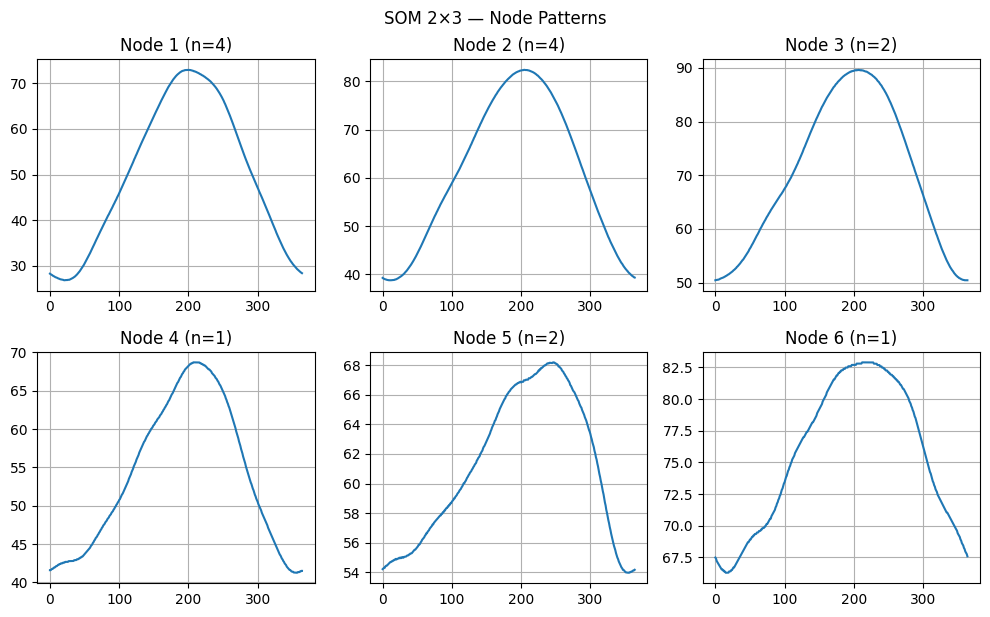

In [ ]:
Nx, Ny = 2, 3
som = MiniSom(x=Nx, y=Ny, input_len=365, sigma=1.0,
              learning_rate=0.5, random_seed=42)
som.train_random(flow, 2000)

bmus = [som.winner(x) for x in flow]
bmu_idx_23 = np.array([i*Ny + j for i,j in bmus])

weights = som.get_weights().reshape(Nx*Ny, 365)

plt.figure(figsize=(10,6))
for i in range(Nx*Ny):
    plt.subplot(Nx, Ny, i+1)
    plt.plot(weights[i])
    plt.title(f"Node {i+1} (n={np.sum(bmu_idx_23==i)})")
    plt.grid(True)

plt.tight_layout()
plt.suptitle("SOM 2×3 — Node Patterns", y=1.02)
plt.show()


## **Interpretation of the SOM 2×3 Node Patterns**

The 2×3 Self-Organizing Map (SOM) identifies six prototype annual flow regimes.
Each subplot shows the representative (prototype) hydrograph shape for one node,
and the value \( n \) indicates how many stations were assigned to that node.

Across all nodes, the timing of the seasonal cycle is consistent:
- flows begin low in winter,
- rise rapidly through spring,
- peak near day 200,
- then decline toward winter.

The differences between nodes are mainly in **magnitude**, **amplitude**, and
**shape** of the annual cycle.

---

### **Node 1 (n = 4) — low flow, sharp seasonal amplitude**
- Lowest flow values among all nodes.  
- Strong, narrow seasonal peak.  
- Represents highly seasonal, snowmelt-dominated basins with low baseflow.

---

### **Node 2 (n = 4) — high-flow seasonal regime**
- Higher flow values throughout the year.  
- Broad, smooth annual peak.  
- Suggests wetter or larger basins with substantial snow accumulation.

---

### **Node 3 (n = 2) — very high seasonal amplitude**
- Among the highest peak magnitudes in the map.  
- Steep rise to an intense snowmelt peak.  
- Likely steep or high-elevation basins with concentrated spring runoff.

---

### **Node 4 (n = 1) — moderate flows with slight asymmetry**
- Flow magnitudes lie between Nodes 1 and 2.  
- Rising limb shows mild irregularities.  
- May reflect mixed rain–snow processes or local hydrologic effects.

---

### **Node 5 (n = 2) — transitional hydrograph with two-stage rise**
- Moderate flows with a gradual early increase, followed by a steeper rise.  
- Peak magnitude lower than Nodes 2–3.  
- Suggests a basin with early rainfall influence and later snowmelt.

---

### **Node 6 (n = 1) — high, stable, and smooth annual flow**
- High values throughout the year.  
- Very smooth and broad annual maximum.  
- Represents a large or hydrologically buffered basin.

---

## **Summary**

The SOM reveals a continuum of hydrologic behavior:
- **Low-flow and highly seasonal basins** (Node 1).  
- **High-flow snowmelt-dominated basins** (Nodes 2, 3, and 6).  
- **Intermediate or transitional regimes** (Nodes 4 and 5).

The station counts \( n \) indicate that the dominant regimes are represented
by Nodes 1 and 2, each containing four stations.


# Part 5) SOM (2x2)

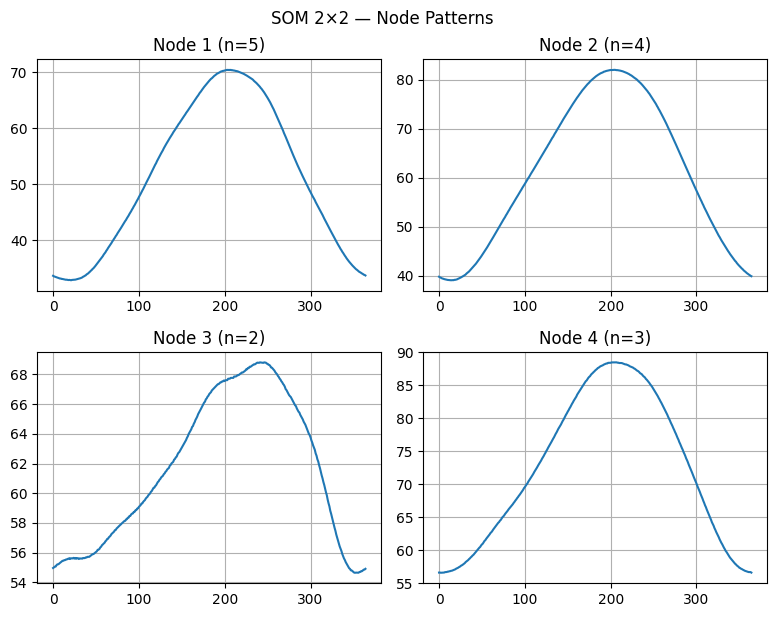

In [ ]:
Nx, Ny = 2, 2
som = MiniSom(x=Nx, y=Ny, input_len=365, sigma=1.0,
              learning_rate=0.5, random_seed=42)
som.train_random(flow, 2000)

bmus = [som.winner(x) for x in flow]
bmu_idx_22 = np.array([i*Ny + j for i,j in bmus])

weights = som.get_weights().reshape(Nx*Ny, 365)

plt.figure(figsize=(8,6))
for i in range(Nx*Ny):
    plt.subplot(Nx, Ny, i+1)
    plt.plot(weights[i])
    plt.title(f"Node {i+1} (n={np.sum(bmu_idx_22==i)})")
    plt.grid(True)

plt.tight_layout()
plt.suptitle("SOM 2×2 — Node Patterns", y=1.02)
plt.show()


## **Interpretation of SOM 2×2 Node Patterns**

The 2×2 SOM groups the 14 annual hydrographs into four representative regimes.
All nodes show similar seasonal timing—with a major peak near day 200
but differ in magnitude, amplitude, and rise/decline shape.

---

### **Node 1 (n = 5) — low-flow, strongly seasonal**
- Lowest values among all nodes.  
- Sharp, narrow peak around day \(200\).  
- Indicates snowmelt-dominated basins with low baseflow and strong seasonal contrast.

---

### **Node 2 (n = 4) — high-flow, broad seasonal regime**
- Higher baseflow values year-round.  
- Broad, smooth annual peak near day \(200\).  
- Represents wetter or larger basins with sustained melt or precipitation input.

---

### **Node 3 (n = 2) — transitional with multi-stage rise**
- Intermediate flow magnitude.  
- Rising limb shows two components (early rise + later melt).  
- Suggests mixed rain–snow processes or complex basin hydrology.

---

### **Node 4 (n = 3) — highest-flow, very smooth hydrograph**
- Highest values throughout the year.  
- Broad, smooth seasonal maximum.  
- Likely large, hydrologically buffered basins with strong and prolonged meltwater supply.

---

## **Summary**

The SOM reveals four major hydrologic regimes:
1. Low-flow, highly seasonal (Node 1),  
2. High-flow, smooth seasonal (Node 2),  
3. Transitional mixed-process basins (Node 3),  
4. High-flow, smooth and sustained basins (Node 4).

These patterns align with other clustering results and highlight a continuum of
snowmelt-influenced flow regimes.


# Part 6) Cluster Frequenciess

In [ ]:
print("\n=== Ward Clustering Frequencies ===")
for k in [2,3]:
    clusters = fcluster(Z, k, criterion="maxclust")
    print(f"\nk = {k}")
    for group in range(1, k+1):
        print(f"Cluster {group}: {np.sum(clusters == group)} stations")

print("\n=== SOM (2×3) Frequencies ===")
unique, counts = np.unique(bmu_idx_23, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Node {u}: {c} stations")

print("\n=== SOM (2×2) Frequencies ===")
unique, counts = np.unique(bmu_idx_22, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Node {u}: {c} stations")


=== Ward Clustering Frequencies ===

k = 2
Cluster 1: 5 stations
Cluster 2: 9 stations

k = 3
Cluster 1: 5 stations
Cluster 2: 3 stations
Cluster 3: 6 stations

=== SOM (2×3) Frequencies ===
Node 0: 4 stations
Node 1: 4 stations
Node 2: 2 stations
Node 3: 1 stations
Node 4: 2 stations
Node 5: 1 stations

=== SOM (2×2) Frequencies ===
Node 0: 5 stations
Node 1: 4 stations
Node 2: 2 stations
Node 3: 3 stations


## **Interpretation of Clustering Frequencies**

The clustering frequencies from Ward hierarchical clustering and the two SOM
models show a consistent hydrologic structure across all methods.

---

### **Ward Clustering (k = 2)**  
- **Cluster 1:** 5 stations  
- **Cluster 2:** 9 stations  

**Meaning:**  
A small, low-flow, strongly seasonal group (5 stations) is clearly separated
from a larger, higher-flow group (9 stations).

---

### **Ward Clustering (k = 3)**  
- **Cluster 1:** 5 stations  
- **Cluster 2:** 3 stations  
- **Cluster 3:** 6 stations  

**Meaning:**  
The 5-station group remains stable.  
The remaining 9 stations split into a smaller transitional group (3) and a larger
high-flow group (6).

---

### **SOM (2×3)**  
Node sizes: **4, 4, 2, 1, 2, 1**

**Meaning:**  
The SOM identifies six prototype regimes:
- two large groups (4 + 4),  
- two medium groups (2 + 2),  
- two single-station nodes (1 + 1),  
indicating both dominant regimes and unique or transitional hydrographs.

---

### **SOM (2×2)**  
Node sizes: **5, 4, 2, 3**

**Meaning:**  
The 5-station low-flow group reappears exactly.  
The remaining stations separate into three sub-groups similar to Ward’s k = 3
clusters.

---

## **Overall Summary**

Across all methods, three patterns are consistent:

1. A **persistent 5-station low-flow, high–seasonality group** appears in every clustering configuration.  
2. The remaining stations form **multiple high-flow subtypes**, which split differently depending on model resolution.  
3. The SOM reveals **transitional and outlier basins** (nodes with \(n = 1\) or \(n = 2\)) that reflect intermediate or unique annual flow behaviors.

These stable patterns indicate a robust hydrologic structure in the dataset:
a core low-flow regime plus several high-flow and transitional regimes.


# What have we learnt?

## **Conclusion — What We Have Learned**

Across all clustering and pattern-analysis methods (Ward, SOM, PCA/SSA), the
stations exhibit a consistent and robust hydrologic structure.



### **1. A stable low-flow, high-seasonality group**
A group of **five stations** consistently forms a tight cluster.  
These basins have:
- the lowest standardized flows,
- strong snowmelt-driven seasonal peaks,
- the sharpest annual amplitude.

This group appears in every method and is never split, indicating a highly
coherent hydrologic regime.

---

### **2. The remaining stations form a continuum of higher-flow regimes**
The other stations separate into:
- a high-flow group, and  
- one or more transitional subgroups.

Different methods partition this continuum differently, but the underlying
structure remains the same: **one low-flow regime and several high-flow
subtypes**.

---

### **3. All stations share similar seasonal timing**
Hydrographs rise in spring, peak near day \(200\), and decline toward winter.  
Differences arise from:
- magnitude,
- smoothness,
- amplitude,
- multi-stage vs. single-stage rises.

Thus, variability is driven by basin characteristics rather than timing shifts.

---

### **4. Transitional and unique stations are hydrologically meaningful**
SOM nodes with \(n = 1\) or \(n = 2\) correspond to basins with mixed
rain–snow influences or atypical seasonal shapes.  
These reflect physically distinct basin responses.

---

### **5. Multiple methods converge on the same structure**
Ward clustering (k = 2 and k = 3), SOM (2×3 and 2×2), and SSA/PCA all reveal:

- one dominant low-flow/snowmelt regime, and  
- multiple variants of a higher-flow melt-driven regime.

---

## **Overall Insight**

The basins align along a clear hydrologic gradient:
1. **Low-flow, highly seasonal basins**,  
2. **Transitional basins**,  
3. **High-flow, broad and smooth snowmelt basins**.

This agreement across several independent methods confirms the robustness of
the identified regimes.
